# Automated Patent Landscaping

This notebook walks through the process of creating a patent landscape as described in the paper [Automated Patent Landscaping](AutomatedPatentLandscaping_2018Update.pdf) (Abood, Feltenberger 2016). The basic outline is:
* load pre-trained word embeddings
* load a seed set of patents and generate the positive and negative training data
* train a deep neural network on the data
* show how to do inference using the model

If you haven't already, please make sure you've setup an environment following the instructions in the [README](README.md) so you have all the necessary dependencies.

Copyright 2017 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Basic Configuration

In [2]:
import tensorflow as tf
import pandas as pd
import os

#seed_name = 'hair_dryer'
#seed_name = 'video_codec'
seed_name = "office_furniture"

## Download Embedding Model if Necessary
We provide a pre-trained word2vec word embedding model that we trained on 5.9 million patent abstracts. See also `word2vec.py` in this repo if you'd like to train your own (though gensim is likely an easier path). The code below will download the model from Google Cloud Storage (GCS) and store it on the local filesystem, or simply load it from local disk if it's already present.

In [3]:
from fiz_lernmodule.word2vec import Word2VecReader

w2v_loader = Word2VecReader(src_dir=src_dir)
w2v_model = w2v_loader.load_word_embeddings()

Load mappings from .\5.9m\vocab\vocab.csv
Load config from .\5.9m\vocab\config.csv
INFO:tensorflow:Restoring parameters from .\5.9m\checkpoints\5.9m_abstracts.ckpt-1325000


## Load Word2Vec Embeddings

This loads Word2Vec embeddings from a model trained on 5.9 million patent abstracts. Just as a demonstration, this also finds the k most similar words to a given word ranked by closeness in the embedding space. Finally, we use tSNE to visualize the word closeness in 2-dimensional space.

Note that the actual model files are fairly large (e.g., the 5.9m dataset is 760mb per checkpoint), so they are not stored in the Github repository. They're stored in the [patent_landscapes](https://console.cloud.google.com/storage/browser/patent_landscapes) Google Cloud Storage bucket under the models/ folder. If you'd like to use them, download the `models` folder and put it into the root repository folder (e.g., if you checked out this repository into the `patent-models` folder, then the `5.9m` model should be in `patent-models/models/5.9m`, for example.

In [4]:
w2v_model.find_similar('codec', 10)

[{'word': 'codecs', 'index': 18666, 'distance': 0.2504613399505615},
 {'word': 'coder', 'index': 7908, 'distance': 0.35244476795196533},
 {'word': 'modem', 'index': 3439, 'distance': 0.4056497812271118},
 {'word': 'audio', 'index': 689, 'distance': 0.42499154806137085},
 {'word': 'pcm', 'index': 6847, 'distance': 0.44711458683013916},
 {'word': 'transcoder', 'index': 14431, 'distance': 0.4494163990020752},
 {'word': 'voice', 'index': 1277, 'distance': 0.4593394994735718},
 {'word': 'dsp', 'index': 7047, 'distance': 0.45978355407714844},
 {'word': 'quantization', 'index': 4256, 'distance': 0.4601200819015503},
 {'word': 'mpeg', 'index': 6996, 'distance': 0.4673845171928406}]

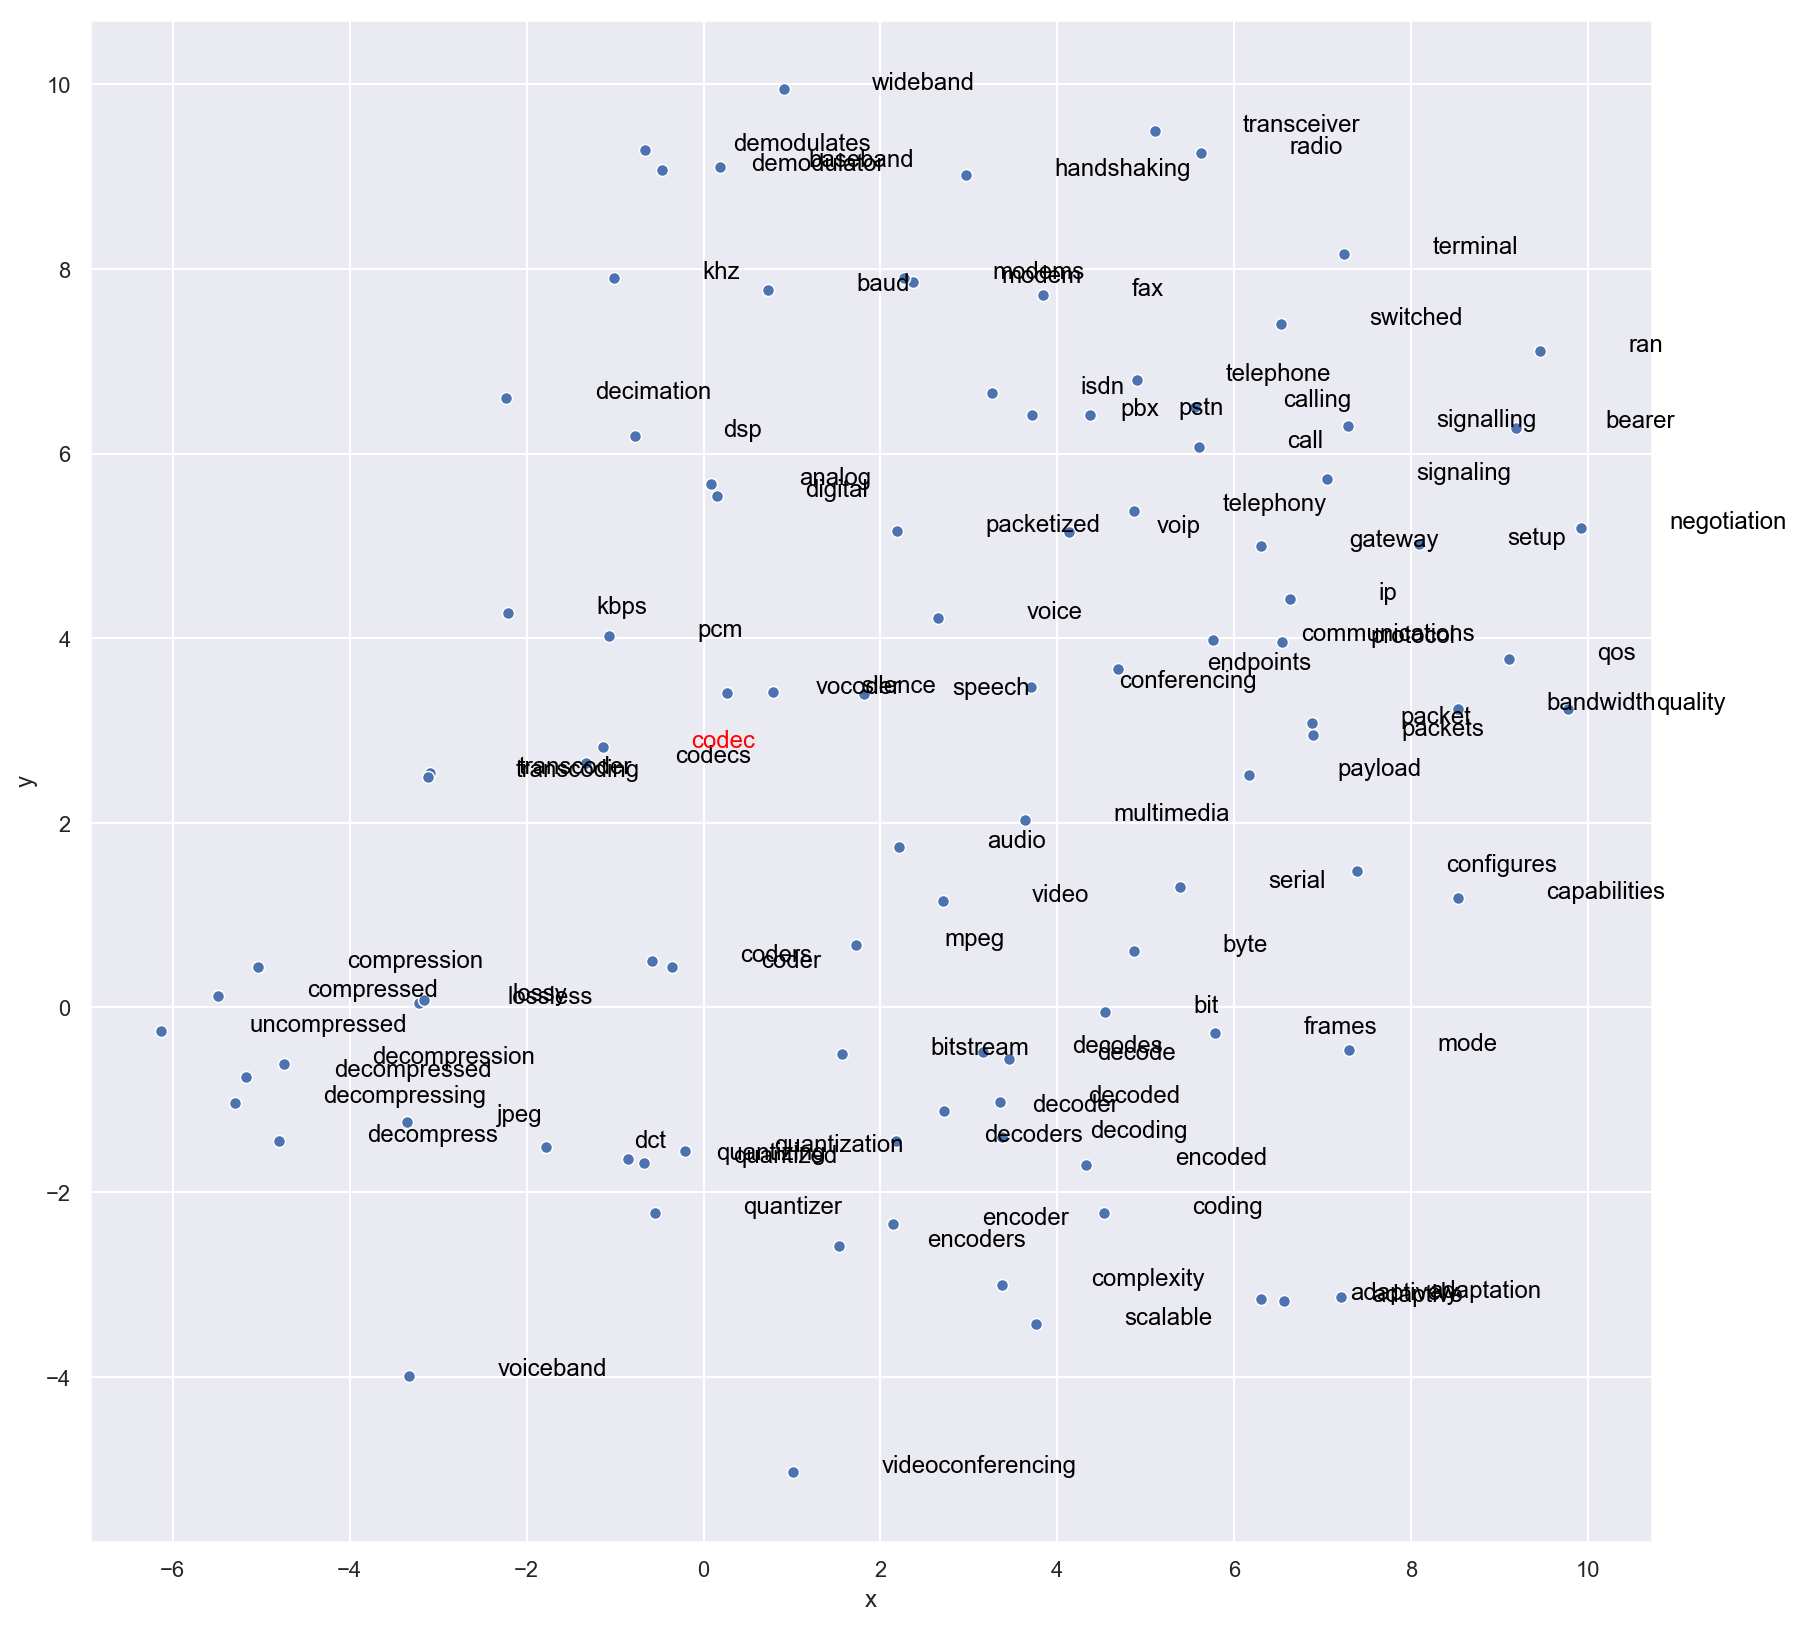

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

w2v_model.visualize_embeddings("codec", 100)

## Patent Landscape Expansion

This section of the notebook creates an instance of the `PatentLandscapeExpander`, which accesses a BigQuery table of patent data to do the expansion of a provided seed set and produces each expansion level as well as the final training dataset as a Pandas dataframe.

This does the actual expansion and displays the head of the final training data dataframe.

In [7]:
from fiz_lernmodule import data_reader

landscape_reader = data_reader.LandscapeDataReader(src_dir=src_dir)
training_data_full_df = landscape_reader.load_data(seed_name=seed_name)

training_df = training_data_full_df[
    ['publication_number', 'title_text', 'abstract_text', 'ExpansionLevel', 'refs', 'cpcs']]
training_data_full_df.head()

Loading landscape data from BigQuery.


C:\Users\tskripnikova\Anaconda3\envs\vis_emb\lib\site-packages\pandas\io\gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


Querying for all US CPC Counts
Querying for Seed Set CPC Counts
Querying to find total number of US patents
Got 21838 relevant seed refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (21838, 1), to patents._l1_tmp


C:\Users\tskripnikova\Anaconda3\envs\vis_emb\lib\site-packages\pandas_gbq\gbq.py:985: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  stacklevel=1,


Completed loading temp table.
Shape of L1 expansion: (20529, 3)
Got 189134 relevant L1->L2 refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (189134, 1), to patents._l2_tmp
Completed loading temp table.
Shape of L2 expansion: (166898, 3)
Size of union of [Seed, L1, and L2]: 176800
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (176800, 1), to patents.antiseed_tmp
Completed loading temp table.


C:\Users\tskripnikova\Anaconda3\envs\vis_emb\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Loading training data text from (17649, 2) publication numbers
Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (17649, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.
Merging labels into training data.
Saving landscape data to data\office_furniture\landscape_data.pkl.


,pub_num,publication_number,country_code,family_id,priority_date,title_text,abstract_text,refs,cpcs,ipcs,assignees_harmonized,ExpansionLevel
0,8961697,US-8961697-B2,US,39562584,20061227,Die-member-cleaning method and apparatus,A method for cleaning a die member having mold...,"FR-2576532-A1,JP-S6287792-U,JP-2003285014-A,US...","B08B3/024,B28B7/386,B28B3/26","B28B7/38,B08B3/02,B08B9/093,B08B9/00,B28B3/26","HITACHI METALS LTD,SUGIO NAOKI",AntiSeed
1,2010089338,US-2010089338-A1,US,42097746,20081015,Child safety tether,"Child safety tether with a care giver vest, a ...","US-5950569-A,US-3721216-A,US-2005229867-A1,US-...",A47D13/086,A62B35/00,STERN GINA,AntiSeed
2,2011068629,US-2011068629-A1,US,39523032,20080520,Power supply arrangement of an elevator,The invention relates to a power supply arrang...,"US-6422351-B2,US-2001008195-A1,US-7085123-B2,U...","Y10T307/625,Y10T307/615,Y10T307/516,B66B1/302",H02J7/34,KONE CORP,AntiSeed
3,9692571,US-9692571-B2,US,55302957,20140812,Signaling of non-virtual reference signals in ...,A first cell transmits a virtual cell identifi...,"US-2012294694-A1,US-2014334402-A1,US-201516368...",H04L5/0051,"H04W4/00,H04L5/00","ALCATEL LUCENT,ALCATEL-LUCENT USA INC",AntiSeed
4,4166193,US-4166193-A,US,25320854,19771128,Insulators with increased surface conductivity...,A solid insulator having high electrical resis...,"US-3361866-A,US-3137633-A,US-3801725-A,US-3962...","H02G5/068,H01B19/04,H01B17/50","H01B17/50,H02G5/06,H01B19/04",BBC BROWN BOVERI & CIE,AntiSeed


### Show some stats about the landscape training data

In [8]:
print('Seed/Positive examples:')
print(training_df[training_df.ExpansionLevel == 'Seed'].count())

print('\n\nAnti-Seed/Negative examples:')
print(training_df[training_df.ExpansionLevel == 'AntiSeed'].count())

Seed/Positive examples:
publication_number    1732
title_text            1732
abstract_text         1732
ExpansionLevel        1732
refs                  1732
cpcs                  1732
dtype: int64


Anti-Seed/Negative examples:
publication_number    9398
title_text            9398
abstract_text         9398
ExpansionLevel        9398
refs                  9398
cpcs                  9398
dtype: int64


## Preparing / Transforming Training Data

The following takes the input landscape training dataframe and transforms it into a format readable by TensorFlow and Keras.

In [9]:
### Concatenating title and abstract, stemming and filtering out stopwords

In [10]:
from fiz_lernmodule.preprocessing import PreProcessor

pre = PreProcessor()

training_df["text_prep"] = training_df["title_text"].str.cat(training_df[["abstract_text"]], sep=" ")
#training_df['text_prep'] = training_df['text_prep'].map(lambda t: pre.preprocess_text(t))

training_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tskripnikova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\tskripnikova\Anaconda3\envs\vis_emb\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\tskripnikova\Anaconda3\envs\vis_emb\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,publication_number,title_text,abstract_text,ExpansionLevel,refs,cpcs,text_prep
0,US-2010099646-A1,W/o/w emulsion composition,A W/O/W emulsion composition having high emuls...,AntiSeed,"US-6497898-B1,US-2008234392-A1,US-5750124-A","A61K8/60,A61Q19/00,B01F17/0085,A61K8/066,A61K8...",emulsion composition emulsion composition high...
1,US-2013064048-A1,"Timepiece dial, and timepiece",To provide a timepiece dial that presents a ri...,AntiSeed,"US-2010220554-A1,US-2004032797-A1,US-201004610...","B44F1/10,G04B19/065,G04B19/10",timepiece dial timepiece provide timepiece dia...
2,US-8820026-B2,Clip for perimeter trim,A single piece sheet metal clip including a tr...,AntiSeed,"US-2014000205-A1,US-5669198-A,US-5937605-A,US-...","E04B9/127,E04B9/30",clip perimeter trim piece sheet metal clip tri...
3,US-9368713-B2,"Piezoelectric film-attached substrate, piezoel...",There is provided a piezoelectric film-attache...,AntiSeed,"US-2008213575-A1,US-2012025668-A1,JP-200911778...","H01L41/18,G01B11/0625,H01L41/29,Y10T29/42,H01L...",piezoelectric film-attached substrate piezoele...
4,US-4235256-A,Damper assembly for gas duct,A damper assembly for closure of a duct for co...,AntiSeed,"US-3996864-A,US-4176673-A,US-4043534-A,US-2902...","F16K3/3165,Y10T137/4259,F16K3/312,F16K3/0281",damper assembly gas duct damper assembly closu...


In [11]:
import fiz_lernmodule.data_preparation

data_prep = fiz_lernmodule.data_preparation.DataPreparation(training_df, w2v_model)
data_prep.prepare_data(percent_train = 0.8, text_column = "text_prep")

Using TensorFlow backend.


No Keras tokenizer supplied so using vocab size (50000) and series to build new one.
No Keras tokenizer supplied so using vocab size (500) and series to build new one.
Randomizing data.
Creating NumPy arrays for train/test set out of randomized training data.
Number of elements in train: 8745
Number of elements in test: 2187
Sequence lengths for embedding layer: median: 62, mean: 63.42561463693539, max: 214.
Using sequence length of 214 to pad LSTM sequences.
Training data is prepared.


In [12]:
data_prep.show_instance_details(3)


Original:
piezoelectric film-attached substrate piezoelectric film element manufacturing provided piezoelectric film-attached substrate piezoelectric film thickness reflection spectrum relation light surface piezoelectric film irradiated irradiation light wavelength irradiation light reflected surface piezoelectric film light irradiation light transmitted piezoelectric film reflected surface electrode reflection spectrum point center part outer peripheral part piezoelectric film reflection spectrum maximum value minimum value reflectance maximum value 0 4

Tokenized:
piezoelectric film attached substrate piezoelectric film element manufacturing provided piezoelectric film attached substrate piezoelectric film thickness reflection spectrum relation light surface piezoelectric film irradiated irradiation light wavelength irradiation light reflected surface piezoelectric film light irradiation light transmitted piezoelectric film reflected surface electrode reflection spectrum point cent

### Show some sample training data

# Train Model

The following cells specify hyperparameters, the neural network architecture (using Keras) and actually trains and tests the model.

The model is generally composed of:
* sequential word embeddings from the patent Abstract of each training instance
* references one-hot encoded into a fully-connected layer
* CPC codes one-hot encoded into a fully-connected layer
* the above three layers concatenated into a final fully-connected layer
* a final, single sigmoid layer with the classification result


### Model Hyperparameters

In [13]:
nn_config = {
    'batch_size': 64, 
    'dropout': 0.4,
    'num_epochs': 4,   
    'lstm_size': 64
}

### Build the Deep Neural Network

In [14]:
import fiz_lernmodule.model

model = fiz_lernmodule.model.LandscapingModel(data_prep, src_dir, seed_name, nn_config)
model.set_up_model_architecture()

Done building graph.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
refs_input (InputLayer)         (None, 50000)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          12800256    refs_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
embed_input (InputLayer)        (None, 214)          0                                            
________________________________________________________________________________________

### Train / Fit the Network

In [15]:
model.train_or_load_model("load")

Model has not been trained yet.
Training model.
Train on 8745 samples, validate on 2187 samples
Epoch 1/4
8745/8745 [==============================] - 58s 7ms/step - loss: 0.1910 - acc: 0.9292 - precision: 0.9891 - recall: 0.9273 - fmeasure: 0.9527 - val_loss: 0.0389 - val_acc: 0.9913 - val_precision: 0.9946 - val_recall: 0.9950 - val_fmeasure: 0.9948
Epoch 2/4
8745/8745 [==============================] - 58s 7ms/step - loss: 0.0632 - acc: 0.9835 - precision: 0.9938 - recall: 0.9871 - fmeasure: 0.9903 - val_loss: 0.0288 - val_acc: 0.9945 - val_precision: 0.9957 - val_recall: 0.9979 - val_fmeasure: 0.9967
Epoch 3/4
8745/8745 [==============================] - 66s 7ms/step - loss: 0.0346 - acc: 0.9906 - precision: 0.9935 - recall: 0.9957 - fmeasure: 0.9945 - val_loss: 0.0264 - val_acc: 0.9945 - val_precision: 0.9968 - val_recall: 0.9968 - val_fmeasure: 0.9968
Epoch 4/4
8745/8745 [==============================] - 62s 7ms/step - loss: 0.0232 - acc: 0.9939 - precision: 0.9962 - recall: 0.9

### Evaluate the Model on the Test Set

Now it is getting interesting. We trained our model and want to evaluate whether it achieves an acceptable performance or not. Therefore, we will check the size of our test size of our test-set.

In [16]:
model.get_test_size()

2187

Subsequently, we let our model predict the classes (Seed, AntiSeed) of these samples.

In [17]:
prediction = model.predict()

 Confusion Matrices are a handy tool to associate a models prediction with the actual labels of the dataset. Hence, we will use such matrix to visualize our results.

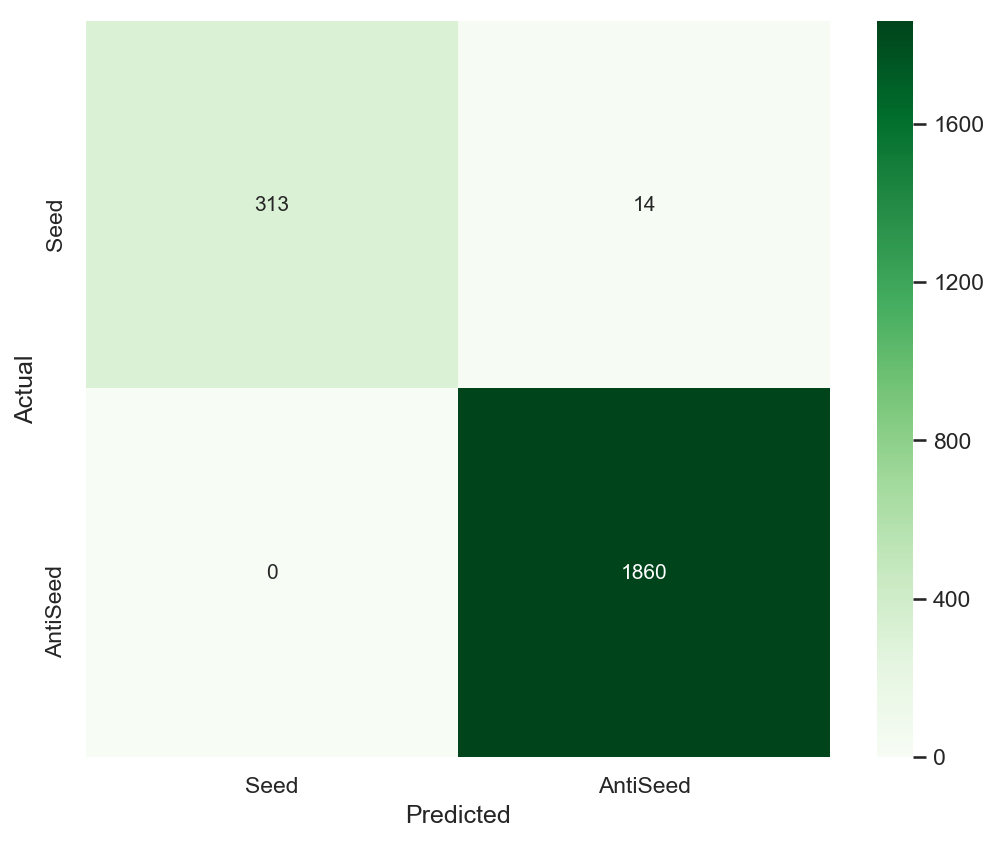

In [18]:
from fiz_lernmodule.confusion import ConfusionMatrix

conf = ConfusionMatrix(model.data.testY, prediction)
conf.plot_matrix(labels=["Seed", "AntiSeed"])

The confusion matrix is basis for the calculation of metrics like accuracy, recall, precision and f1 measure. Before we derive these metrics, we will sample a single example for our test set.

In [19]:
model.get_test_sample()

Index: 6765

Original:
secure over-the-air registration cordless telephones registration portable unit utilized communication system network controller data base storing portable identification numbers base station portable unit subscriber communicates network controller information set subscriber qualifying information portable identification number key code entered portable subscriber entered link identification number over-the-air registration memory portable unit registration steps portable unit sends base station request registration request registration link identification number over-the-air registration portable identification number base station receives request registration portable unit sends network controller notice request registration portable identification number network controller receives notice request registration base station determines portable identification number network controller data base subscriber approved registration network controller sends portable un

### Learning curve

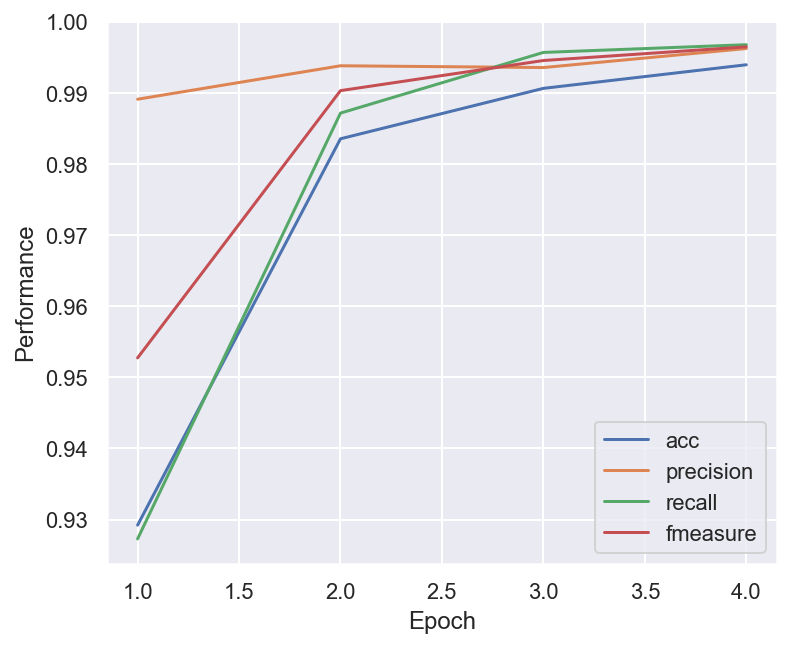

In [20]:
from fiz_lernmodule import visualization_landscaping

if hasattr(model.tf_model, 'history'):
    lcv = visualization_landscaping.LearningCurveVisualizer(model.tf_model)
    lcv.plot_metrics('acc', 'precision', 'recall', 'fmeasure')

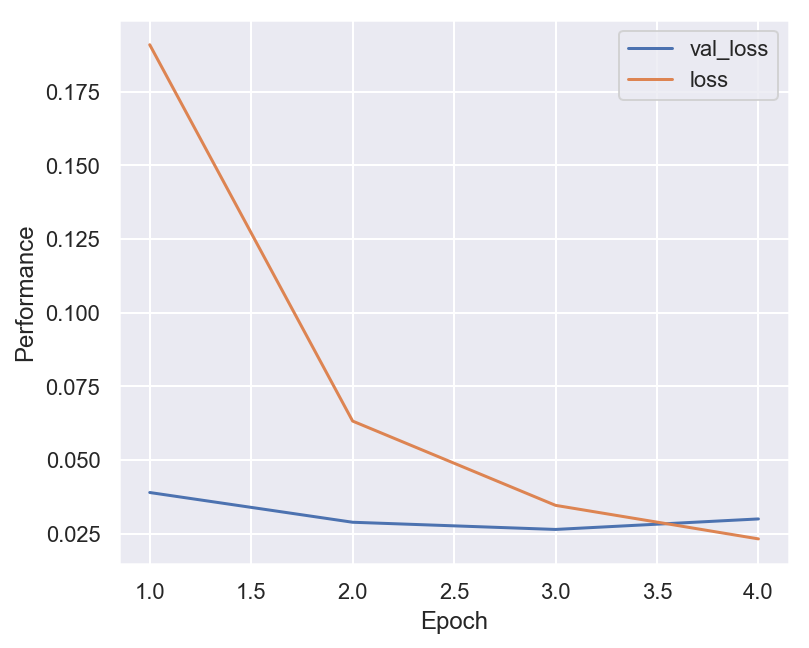

In [21]:
if hasattr(model.tf_model, 'history'):
    lcv.plot_metrics('val_loss', 'loss')

## Generate Document embeddings

This tutorial referred to patent landscaping as the process of finding patents related to a certain topic. We tackled this task by using a deep neural network as a classifier to distinguish between two classes (seed and antiseed). The resulting classification for a certain patent is similar to its membership to the topic of the seed set.Nevertheless, this classification only assigns a label to a pre-processed patent.
But wouldn't it be nice to actually visualize the patent landscape?

The activations of our neural network are nothing else than continuous vector representations of our inputs (with less dimensions). We use the following cell to extract the activations of our model while predicting the test set. 

We'll consider two types of such document embeddings.
We will use the final layer of our network (64 dimensional).
We will use the average of our pre-trained word embeddings (300-dimensional).

Let's see how they differ. One could naively assume that the first option may lead to a clearer distinction since it incorporates layers of non-linear transformation on top of the word embeddings. Although, the dimensionality of this vector is lower.

In [22]:
final_layer_test = model.get_final_layer_as_document_embedding("test")
final_layer_test.shape

(2187, 64)

In [23]:
final_layer_train = model.get_final_layer_as_document_embedding("train")
final_layer_train.shape

(8745, 64)

In [24]:
final_layer = pd.concat([final_layer_train, final_layer_test])

with open(src_dir + "/data/" + seed_name + "/final_layer_embedding.pkl", 'wb') as outfile:
    pickle.dump(final_layer, protocol=pickle.HIGHEST_PROTOCOL)